# Pretained Model

In this experiment we load a pretrained model to solve the image classification task in the CIFAR10 dataset. PyTorch provides a wide variety of pre built arquitectures, such as AlexNet, Inception, MobileNet, etc., for the majority of these arquitectures PyTorch also gives us the option to load the weights pretrained on ImagerNet. For this specific experiment, we implement a model based on ResNet, more specifically ResNet18, making use of its pretrained weights.

For us to be able to build any sort of deep learning model we need to call the following libraries.

In [20]:
# Display image
from matplotlib.pyplot import imshow
# General purposes
import numpy as np
import pandas as pd
# torch custom module
import sys
sys.path.append('../')
import torch_utils
# PyTorch stuff
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader 
import torch.optim as optim
# ResNet model
from torchvision.models import resnet18

## 1. Dataset

In the next cell, we define the set of transforms that will be applied to the images before passing to the network. Since we'll be using a pretrained network, we need to be very careful when applying transforms to the images, because the network is already used to see images with a defined size, whose values lie within an especific range. Fourtunately, in most cases, PyTorch tells us what transforms we need to implement when using each of its pretrained models. 

In this case, the right image preprocessing for a ResNet model is the following 

In [21]:
custom_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Now, we download the Fashion-MNIST data set

In [22]:
train_data = CIFAR10(root='../../data', train=True, download=True, transform=custom_transforms)
valid_data = CIFAR10(root='../../data', train=False, download=True, transform=custom_transforms)

Files already downloaded and verified
Files already downloaded and verified


We can create a list with the classes

In [23]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let's see how do the images look like 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
frog


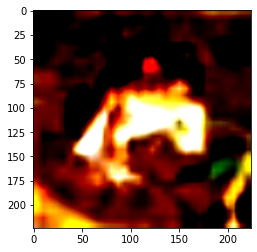

In [24]:
image, label = train_data[0]
print(classes[label])
imshow(image.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
cat


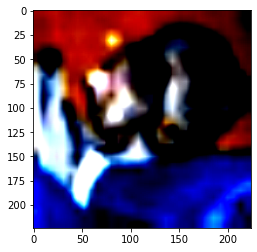

In [25]:
image, label = valid_data[0]
print(classes[label])
imshow(image.permute(1, 2, 0))

For being able to pass the data to the neural networks we need to use a dataloader object

In [26]:
train_dataloader = DataLoader(dataset=train_data, batch_size=5, shuffle=True)
valid_dataloader = DataLoader(dataset=valid_data, batch_size=5, shuffle=True)

## 2. Networks 

In this section we'll define the neural network we are going to work with. As mentioned above, we wish to use a pretrained ResNet model. 

In the next cell we define a function which returns, after providing the number of clases and especifying if we want to load the pretrained weights into our network, a ResNet18 arquiteture ready for use.

In [27]:
def resnet_based_model(num_classes = 10, pretrained = False):

    network = resnet18(pretrained = pretrained)
    fc_input_size = network.fc.in_features
    network.fc = nn.Linear(in_features = fc_input_size, out_features = num_classes, bias = True)

    return network

Let's take a moment to try to make sense of what the above code is doing. First we call the resnet18 module, which return the ResNet18 a aquitecutre which outputs a vector os size 1000, this makes sense if we consider teh fact that ResNet arquitectures were originally created to accomplish the ImageNet classifiaction problem, which has 1000 classes. After that, we replace this faully connected layer for another fully connected whose output size fits the number of classes of our specific problem.

Given that the resnet18 module delivers a function, instead of a class, we cannot create a son class that adds the summary functionality. However, we can display a summary of the model as follows

In [28]:
resnet18_net = resnet_based_model(num_classes=10, pretrained=True)
torch_utils.network_summary(resnet18_net, input_size=(3,224,224))

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 

## 3. Taining the Model

### 3.1 _Freezing_ the Weights

Since we are using a pretrained model, we wish to train only the last layer's weights, _freezing_ the weights of the rest of the network during the trainig process. This procedure is known as transfer learning. 



In [29]:
for name, parameters in resnet18_net.named_parameters(): 
    # We freeze all the layers but the normalization ones and the fully connected layer
    if ('bn' not in name) and ('fc' not in name):
        parameters.requires_grad = False

We can check the number of trainable parameters by displaying the model's summary

In [30]:
torch_utils.network_summary(resnet18_net, input_size=(3,224,224))

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1

### 3.2 Loss Function and Optimizer

Now, we define the loss function and the optimizer for our model.

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18_net.parameters(), lr=0.001, momentum=0.9)

### 3.3 Training 

Finaly, we train de model.

In [32]:
num_epochs = 2

trained_net, metrics_history = torch_utils.train_network(
                                    network = resnet18_net, 
                                    epochs = num_epochs, 
                                    train_dataloader = train_dataloader, 
                                    valid_dataloader = valid_dataloader, 
                                    loss_fn = loss_fn, 
                                    optimizer = optimizer)

Epoch: 1 || Train loss = 0.0, Train Acc = 0.0, Valid Loss = 0.0, Valid Acc = 0.0
Epoch: 2 || Train loss = 0.0, Train Acc = 0.02, Valid Loss = 0.0, Valid Acc = 0.1
Finished Training, Hurray!!! :D


## 4. Testing

Usually, when creating and training machine learning models, one has to make sure to have three datasets, the training set, the validation set and the testing set. The testing set has the purpose to help us evaluate the model's performance once the training process is finished, in constrast with the validation set, which is used for keep track of the model's performance during the training process. 

Unfortunately, the CIFAR10 dataset only provides the training and the validation sets. However, for illustrative purposes only, down bellow we evaluate our model on the validation set. We want to stress the fact that, in real life applications or research, we must perform the testing of our model on a set that's disjoint form the training and velidation sets.